# HW3 : Neural Networks and Stochastic Gradient Descent

This is the starter notebook for HW3.

### Instructions

The authoritative HW3 instructions are on the course website:

http://www.cs.tufts.edu/comp/135/2023f/hw3.html

Please report any questions to Piazza.

We've tried to make random seeds set explicitly so you can reproduce these exact results, but remember that some differences across platforms might occur, so the exact count of how many runs "converge" or not may not be precise (though hopefully in the same ballpark).

### Outline of this Notebook


* [Problem 1: MLP with LBFGS](#part1): How many hidden units should we pick?
* [Problem 2: MLP with SGD](#part2): What batch size and learning rate should we pick?

In [1]:
import os
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier
import sklearn.metrics


In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')


In [3]:
# Used for some bonus visualizations

from viz_tools_for_binary_classifier import plot_pretty_probabilities_for_clf


# Load the "Flower XOR" dataset


10,000 labeled examples in training set

Each example has 2 features ($x_{n1}, x_{n2}$)

Each label is binary (0 or 1)

In [4]:
DATA_DIR = "./data_flower" 


In [5]:
# Load training data
x_tr_N2 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), skiprows=1, delimiter=',')
y_tr_N = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), skiprows=1, delimiter=',')

# Load test data
x_te_T2 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), skiprows=1, delimiter=',')
y_te_T = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), skiprows=1, delimiter=',')

assert x_tr_N2.shape[0] == y_tr_N.shape[0]
assert x_te_T2.shape[0] == y_te_T.shape[0]


Text(0, 0.5, 'x_2')

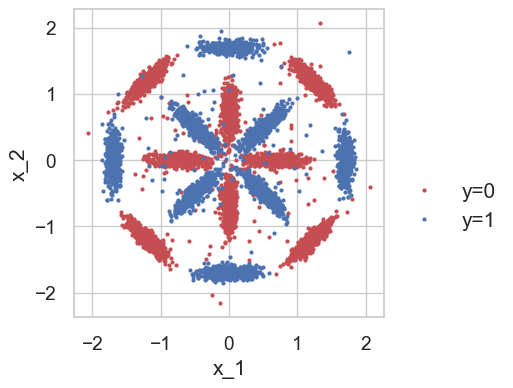

In [6]:
fig, _ = plt.subplots(figsize=(4,4))
plt.plot(x_tr_N2[y_tr_N == 0,0], x_tr_N2[y_tr_N == 0,1], 'r.', label='y=0')
plt.plot(x_tr_N2[y_tr_N == 1,0], x_tr_N2[y_tr_N == 1,1], 'b.', label='y=1')
plt.legend(bbox_to_anchor=[1.0, 0.5], fontsize=15)
plt.xlabel('x_1'); plt.ylabel('x_2')


# Problem 1: MLP with L-BFGS solver - What model size is best?

Let's train an MLP at each of several different sizes.

For this problem, we'll use the `solver='lbfgs'`

We'll try multiple runs of the optimizer, to see what the impact of different random initializations of parameters is.

In [7]:
size_list = [4, 16, 64, 256]
n_runs = 4

S = len(size_list)

tr_loss_arr = 0.11 * np.ones((S, n_runs)) # Pre allocate with arbitrary values, just so code doesnt break
te_loss_arr = 0.22 * np.ones((S, n_runs))

tr_err_arr = 0.08 * np.ones((S, n_runs))
te_err_arr = 0.13 * np.ones((S, n_runs))


In [12]:
max_iter_per_run = 1000

for size in size_list:
    
    for run_id, random_state in enumerate(range(n_runs)):
        
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=[size],
            activation='relu',
            alpha=0.0001,
            tol=1e-5,
            max_iter=max_iter_per_run,
            random_state=random_state,
            solver='lbfgs', batch_size=10000,
            
            )
        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        elapsed_time_sec = time.time() - start_time_sec
        mlp.did_converge = True if len(warn_list) == 0 else False

        tr_log_loss = sklearn.metrics.log_loss(y_tr_N, mlp.predict_proba(x_tr_N2)) / np.log(2)
        te_log_loss = sklearn.metrics.log_loss(y_te_T, mlp.predict_proba(x_te_T2)) / np.log(2)
        
        tr_err = sklearn.metrics.zero_one_loss(y_tr_N, mlp.predict(x_tr_N2), normalize=True)
        te_err = sklearn.metrics.zero_one_loss(y_te_T, mlp.predict(x_te_T2), normalize=True)
        
        tr_loss_arr[run_id] = tr_log_loss
        te_loss_arr[run_id] = te_log_loss
        
        tr_err_arr[run_id] = tr_err
        te_err_arr[run_id] = te_err

        print(
            'layer_sizes %3d: run %d/%d done after %5.1f sec | %13s after %3d iter | tr err %.3f | te err %.3f' % (
            size, 
            run_id + 1, n_runs, elapsed_time_sec,
            'yes converged' if mlp.did_converge else 'NOT converged',
            max_iter_per_run,
            tr_err, te_err))


layer_sizes   4: run 1/4 done after   0.5 sec | yes converged after 1000 iter | tr err 0.258 | te err 0.267
layer_sizes   4: run 2/4 done after   0.1 sec | yes converged after 1000 iter | tr err 0.300 | te err 0.303
layer_sizes   4: run 3/4 done after   0.2 sec | yes converged after 1000 iter | tr err 0.359 | te err 0.358
layer_sizes   4: run 4/4 done after   0.1 sec | yes converged after 1000 iter | tr err 0.213 | te err 0.210
layer_sizes  16: run 1/4 done after   2.4 sec | yes converged after 1000 iter | tr err 0.016 | te err 0.015
layer_sizes  16: run 2/4 done after   3.4 sec | NOT converged after 1000 iter | tr err 0.016 | te err 0.022
layer_sizes  16: run 3/4 done after   1.1 sec | yes converged after 1000 iter | tr err 0.021 | te err 0.024
layer_sizes  16: run 4/4 done after   3.6 sec | NOT converged after 1000 iter | tr err 0.039 | te err 0.043
layer_sizes  64: run 1/4 done after  10.3 sec | NOT converged after 1000 iter | tr err 0.008 | te err 0.015
layer_sizes  64: run 2/4 don

## For fun and understanding, visualize the latest run's learned MLP

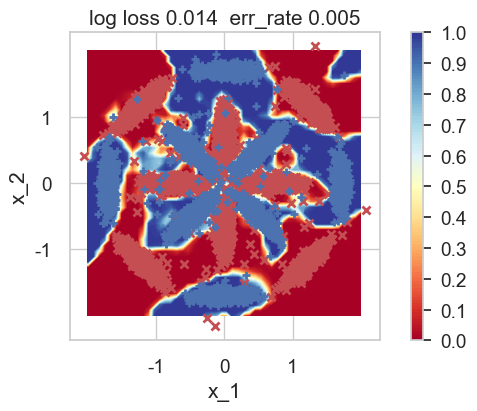

In [13]:
fig, ax_handle = plt.subplots(nrows=1, ncols=1, figsize=(4, 4));
plot_pretty_probabilities_for_clf(mlp, x_tr_N2, y_tr_N, ax=ax_handle, do_show_colorbar=True);
plt.xlabel('x_1'); plt.ylabel('x_2');


## Figure 1 (left): Log loss vs size

TODO if you've filled in the `tr_loss_arr` and `te_loss_arr` correctly so it has shape (S,R) with S sizes and R runs, this code should make a nice plot for you.

Each dot in the plot represents one completed run of the optimizer from a random initialization.


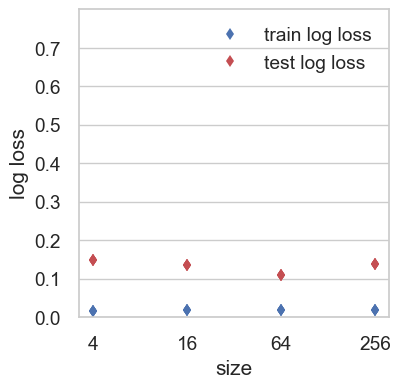

In [14]:
fig, loss_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train log loss' if run_id == 0 else ''
    te_label = 'test log loss' if run_id == 0 else ''
    
    loss_ax.plot(np.log2(size_list), tr_loss_arr[:,run_id], 'bd', label=tr_label)
    loss_ax.plot(np.log2(size_list), te_loss_arr[:,run_id], 'rd', label=te_label)

loss_ax.set_xticks(np.log2(size_list));
loss_ax.set_xticklabels(size_list);
loss_ax.xaxis.grid(False);

loss_ax.set_ylim([0, 0.8]); # Don't touch this please
loss_ax.set_yticks(np.arange(0, 0.8, 0.1));

loss_ax.set_ylabel('log loss');
loss_ax.set_xlabel('size');
loss_ax.legend(loc='upper right');


## Figure 1 (right): Error vs size

TODO if you've filled in the `tr_err_arr` and `te_err_arr` correctly so it has shape (S,R) with S sizes and R runs, this code should make a nice plot for you.


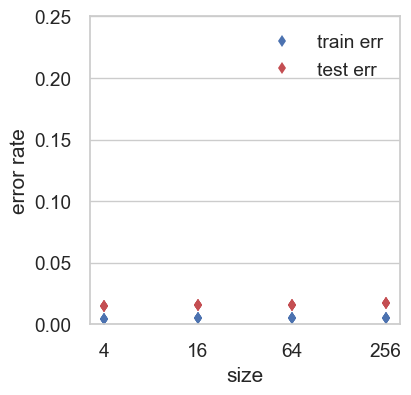

In [16]:
fig, err_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train err' if run_id == 0 else ''
    te_label = 'test err' if run_id == 0 else ''
    
    err_ax.plot(np.log2(size_list), tr_err_arr[:,run_id], 'bd', label=tr_label)
    err_ax.plot(np.log2(size_list), te_err_arr[:,run_id], 'rd', label=te_label)

err_ax.set_xticks(np.log2(size_list));
err_ax.set_xticklabels(size_list);
err_ax.xaxis.grid(False);

err_ax.set_ylim([0, 0.25]); # Don't touch this please

err_ax.set_ylabel('error rate');
err_ax.set_xlabel('size');
err_ax.legend(loc='upper right');


# Setup for Problem 2

Helper code for plotting training loss as more data is seen.

The second argument 'x' can be adjusted by user so you plot loss versus *time* or loss versus *epochs*

In [17]:
def pretty_plot_loss_curve_vs_x(mlp_list_by_lr, x='elapsed_time_sec', xlim_max=65, ylim_max=0.5):
    ''' Create pretty plot of loss as more data is seen.

    Args
    ----
    mlp_list_by_lr : dict of lists
        Each key is a learning rate.
        Each value is a list of MLPClassifier objects
    x : str
        Either 'elapsed_time_sec' or 'epoch'
        
    Post Condition
    --------------
    Creates new matplotlib figure and plots a line:
    * loss on y-axis
    * the specified x variable on x-axis
    '''

    ncols = len(mlp_list_by_lr)
    fig, ax = plt.subplots(
        nrows=1, ncols=ncols, figsize=(ncols*4, 4),
        squeeze=False,
        sharex=True, sharey=True)
    ax = ax.flatten()
    for ii, (lr, mlp_list) in enumerate(mlp_list_by_lr.items()):
        for mlp in mlp_list:
            if x.count("time"):
                ax[ii].plot(
                    mlp.elapsed_time_sec_ * np.linspace(1.0/mlp.n_iter_, 1.0, mlp.n_iter_),
                    mlp.loss_curve_ / np.log(2.0), '-')
                ax[ii].set_xlabel('elapsed time (sec)');
            else:
                ax[ii].plot(
                    np.arange(mlp.n_iter_),
                    mlp.loss_curve_ / np.log(2.0), '-')
                ax[ii].set_xlabel('epochs completed');

        ax[ii].set_title('lr %.3f \n batch_size %d' % (lr, mlp.batch_size))

        if ii == 0:
            ax[ii].set_ylabel('log loss');
        ax[ii].set_ylim([0.0, ylim_max]);
        ax[ii].set_xlim([0.0, xlim_max]);


# Problem 2: MLP with SGD : Which batch size and learning rate is best?

This problem requires you to *interpret* a provided plot.

No coding required! 

See the [HW3 Instructions page](https://www.cs.tufts.edu/cs/135/2023f/hw3.html#problem-2)


### Goal of this problem: Can we become more scalable with SGD?

There are N=10000 training examples in our training set. Can we use SGD to train our model faster?

We'll fix our model size to 64 hidden units.

Let's try out classic "sgd" (stochastic gradient descent), at a few different batch sizes and learning rates.

Remember, what happens in SGD is given by the pseudocode on the [HW3 Instructions page background section on SGD](https://www.cs.tufts.edu/cs/135/2023f/hw3.html#SGD)

### Vocabulary: What is an iteration in SGD?

Sometimes this word means different things in different contexts. We'll focus on what it means using sklearn's implementation.

Each *iteration* (also called an *epoch*) represents one or more gradient computation and parameter update steps (see pseudocode above).

Each iteration is complete when the number of examples it has ``seen'' (and used for updates) is equal to (or slightly bigger than) the total number examples in the entire training dataset. This number is denoted as N in our code above.

Thus, the number of parameter updates that happen per iteration depends on the `batch_size`.

# Problem 3: MLP with SGD : Your own re-implementation

Can you reproduce the figure you analyzed in Problem 2?


## Reproduce Figure 2 step 1: Try with batch_size = 10000 (each batch sees 100% of the dataset)

We expect each separate "run" will take between 1-3 minutes.

We want you to try at least 2 runs at each of 4 learning rates.

So this block may take ~10-20 minutes to run.

In [18]:
layer_sizes = [64]
n_runs = 2
lr_list = [0.1, 0.3, 0.9, 2.7]


In [19]:
batch_size = 10000
max_iter_per_run = 8000 # Don't touch. Has been set so wallclock times are comparable.

mlp_list_by_lr_10000 = dict()

for lr in lr_list:
    mlp_list_by_lr_10000[lr] = list()
        
    for run_id, random_state in enumerate(range(n_runs)):

        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            activation='relu',
            alpha=0.0001,
            random_state=random_state, # controls random init of weights
            max_iter=max_iter_per_run,
            solver='sgd',
            batch_size=batch_size,
            learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )
        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        mlp.elapsed_time_sec_ = time.time() - start_time_sec
        mlp.n_epoch_ = len(mlp.loss_curve_)
        mlp.did_converge = True if len(warn_list) == 0 else False

        # Add to the list
        mlp_list_by_lr_10000[lr].append(mlp)
        
        # Pretty print summary of this run
        msg = 'finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | lr = %.3f' % (
            run_id + 1, n_runs,
            mlp.elapsed_time_sec_,
            'yes converged' if mlp.did_converge else 'NOT converged',
            mlp.n_epoch_,
            mlp.loss_ / np.log(2.0),
            lr)
        mlp.msg = msg
        print(msg)


finished run  1/2 after  92.0 sec | yes converged after 7474 iter | tr loss  0.195 | lr = 0.100
finished run  2/2 after  96.0 sec | yes converged after 7493 iter | tr loss  0.198 | lr = 0.100
finished run  1/2 after  73.7 sec | yes converged after 5058 iter | tr loss  0.221 | lr = 0.300
finished run  2/2 after  63.1 sec | yes converged after 4695 iter | tr loss  0.224 | lr = 0.300
finished run  1/2 after  76.9 sec | yes converged after 5328 iter | tr loss  0.162 | lr = 0.900
finished run  2/2 after  71.7 sec | yes converged after 5343 iter | tr loss  0.170 | lr = 0.900
finished run  1/2 after  36.5 sec | yes converged after 2784 iter | tr loss  0.164 | lr = 2.700
finished run  2/2 after  48.0 sec | yes converged after 3796 iter | tr loss  0.146 | lr = 2.700


### Plot loss trace versus elapsed time

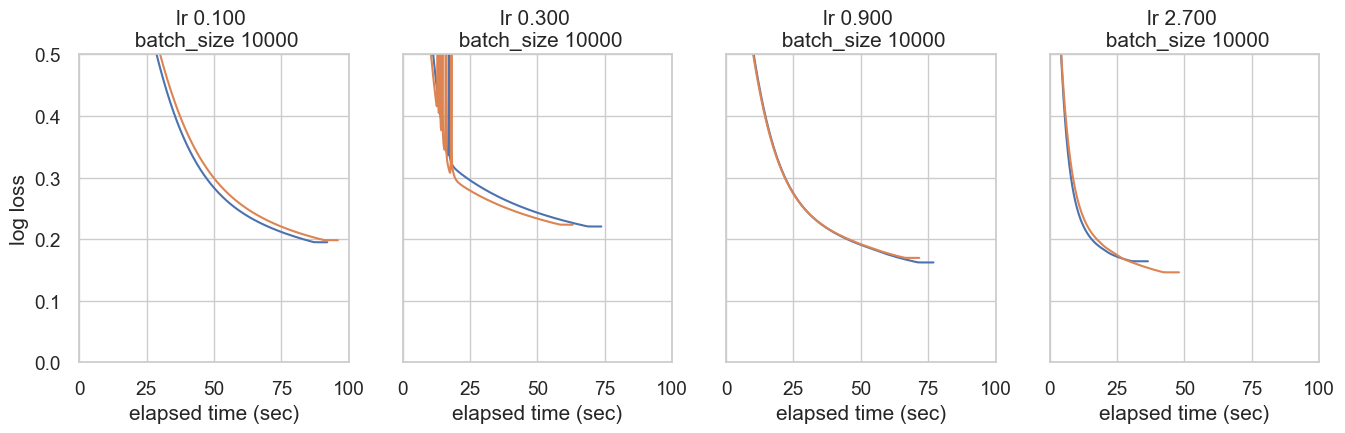

In [21]:
pretty_plot_loss_curve_vs_x(mlp_list_by_lr_10000, x='elapsed_time_sec', xlim_max=100, ylim_max=0.5);


## Reproduce Figure 2 step 2: Try with batch_size = 500 (each batch sees ~5% of the dataset)

We expect each separate "run" will take between 1-3 minutes.

We want you to try at least 2 runs at each of 4 learning rates.

So this block may take ~10-20 minutes to run.

In [22]:
batch_size = 500

max_iter_per_run = 2000 # Don't touch. Has been set so wallclock times are comparable.

mlp_list_by_lr_500 = dict()
for lr in lr_list:
    mlp_list_by_lr_500[lr] = list()
    for run_id, random_state in enumerate(range(n_runs)):
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            activation='relu',
            alpha=0.0001,
            random_state=random_state, # controls random init of weights
            max_iter=max_iter_per_run,
            solver='sgd',
            batch_size=batch_size,
            learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )

        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        mlp.elapsed_time_sec_ = time.time() - start_time_sec
        mlp.n_epoch_ = len(mlp.loss_curve_)
        mlp.did_converge = True if len(warn_list) == 0 else False

        # Add to the list
        mlp_list_by_lr_500[lr].append(mlp)
        
        # Pretty print summary of this run
        print('finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | lr = %.3f' % (
            run_id + 1, n_runs,
            mlp.elapsed_time_sec_,
            'yes converged' if mlp.did_converge else 'NOT converged',
            mlp.n_epoch_,
            mlp.loss_ / np.log(2.0),
            lr))


finished run  1/2 after  28.0 sec | NOT converged after 2000 iter | tr loss  0.102 | lr = 0.100
finished run  2/2 after  26.9 sec | NOT converged after 2000 iter | tr loss  0.106 | lr = 0.100
finished run  1/2 after  26.8 sec | yes converged after 1793 iter | tr loss  0.090 | lr = 0.300
finished run  2/2 after  26.8 sec | yes converged after 1790 iter | tr loss  0.095 | lr = 0.300
finished run  1/2 after  16.1 sec | yes converged after  843 iter | tr loss  0.129 | lr = 0.900
finished run  2/2 after  14.2 sec | yes converged after  990 iter | tr loss  0.104 | lr = 0.900
finished run  1/2 after  25.3 sec | yes converged after 1760 iter | tr loss  0.081 | lr = 2.700
finished run  2/2 after  11.5 sec | yes converged after  700 iter | tr loss  0.148 | lr = 2.700


### Plot loss trace versus elapsed time

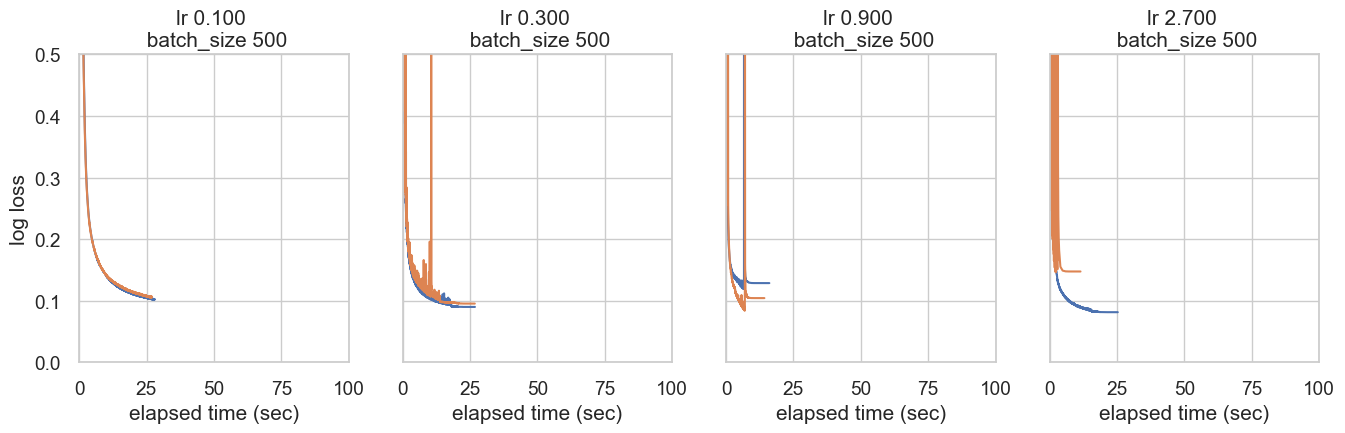

In [23]:
pretty_plot_loss_curve_vs_x(mlp_list_by_lr_500, x='elapsed_time_sec', xlim_max=100, ylim_max=0.5);


## Reproduce Figure 2c: Try with batch_size = 25 (tiny! each batch sees ~0.2% of the dataset)

We expect each separate "run" will take between 1-3 minutes.

We want you to try at least 2 runs at each of 4 learning rates.

So this block may take ~10-20 minutes to run.

In [24]:
batch_size = 25

max_iter_per_run = 500 # Don't touch. Has been set so wallclock times are comparable.

mlp_list_by_lr_25 = dict()
for lr in lr_list:
    mlp_list_by_lr_25[lr] = list()
    for run_id, random_state in enumerate(range(n_runs)):
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            activation='relu',
            alpha=0.0001,
            random_state=random_state, # controls random init of weights
            max_iter=max_iter_per_run,
            solver='sgd',
            batch_size=batch_size,
            learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )

        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        mlp.elapsed_time_sec_ = time.time() - start_time_sec
        mlp.n_epoch_ = len(mlp.loss_curve_)
        mlp.did_converge = True if len(warn_list) == 0 else False

        # Add to the list
        mlp_list_by_lr_25[lr].append(mlp)
        
        # Pretty print summary of this run
        print('finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | lr = %.3f' % (
            run_id + 1, n_runs,
            mlp.elapsed_time_sec_,
            'yes converged' if mlp.did_converge else 'NOT converged',
            mlp.n_epoch_,
            mlp.loss_ / np.log(2.0),
            lr))


finished run  1/2 after  12.4 sec | NOT converged after  500 iter | tr loss  0.092 | lr = 0.100
finished run  2/2 after  12.4 sec | NOT converged after  500 iter | tr loss  0.091 | lr = 0.100
finished run  1/2 after  12.3 sec | NOT converged after  500 iter | tr loss  0.091 | lr = 0.300
finished run  2/2 after  12.2 sec | NOT converged after  500 iter | tr loss  0.080 | lr = 0.300
finished run  1/2 after  12.1 sec | NOT converged after  500 iter | tr loss  0.076 | lr = 0.900
finished run  2/2 after  12.0 sec | NOT converged after  500 iter | tr loss  0.101 | lr = 0.900
finished run  1/2 after  11.7 sec | NOT converged after  500 iter | tr loss  1.000 | lr = 2.700
finished run  2/2 after  11.7 sec | NOT converged after  500 iter | tr loss  1.000 | lr = 2.700


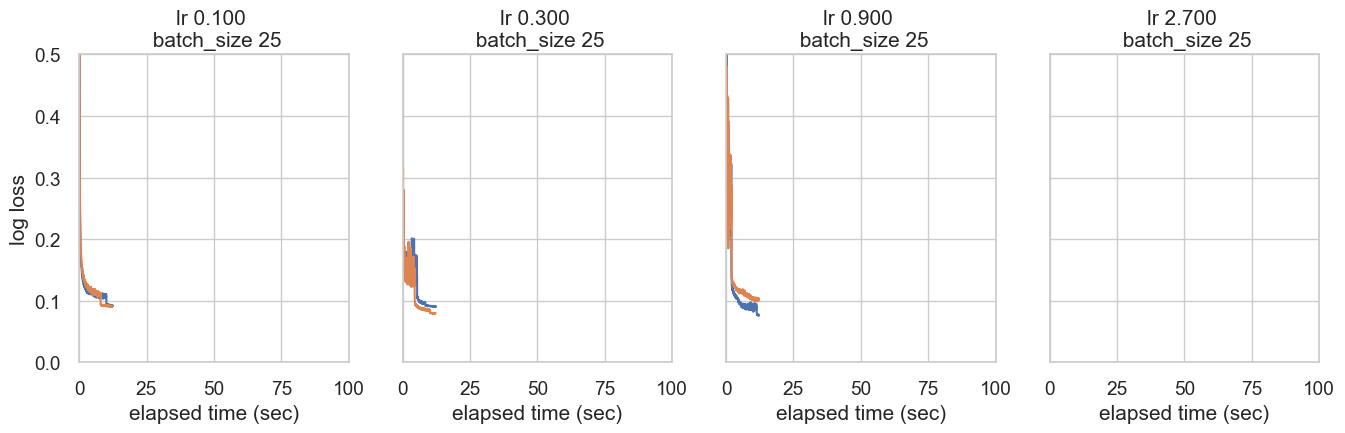

In [25]:
pretty_plot_loss_curve_vs_x(mlp_list_by_lr_25, x='elapsed_time_sec', xlim_max=100, ylim_max=0.5);
